# May 24 final review

Suggestions from students about how to study: https://PollEv.com/discourses/gFCtSJE1KXATAXls02RMz/respond

## Logistics 

- exam begins Monday May 31 at 8am
- Due Friday June 4 at 5p for 1ec point 
- automatic extension to Sun June 6 at 11:59p
- graded on effort (1pt) and accuracy (1pt)
- make sure you show your work!!! 
- DEI survey + final course evaluation -- replace worst homework grade 

## Today

- study tips (polleverywhere)
- second half review 
--- state space control 
--- frequency analysis
--- frequency control

## cruise control

problem from: https://ctms.engin.umich.edu/CTMS/index.php?example=CruiseControl&section=SystemModeling#:~:text=The%20purpose%20of%20the%20cruise,according%20to%20a%20control%20law.

![cruiseCtl](https://drive.google.com/uc?id=1nUmXR2yx4QRbMvJDuB7BrmXScMVc3BiN)

$$m\dot{v}+bv=u$$

$$y=v$$

$m=1000$ kg (vehicle mass)

$b = 50$ Ns/m (dampening coefficient)

## week 6: state space control

In [1]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# animation
from matplotlib import animation as ani
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym


In [4]:
# test whether this is a Colaboratory or Jupyter notebook
try:
  import google.colab
  COLAB = True
  print('Colaboratory Notebook')
except:
  COLAB = False
  print('Jupyter Notebook')
# Colab notebook
if COLAB:
  # pip = Python package manager; "!" means "run at system level"
  !pip install control
  !pip install JSAnimation
  
  # render SymPy equations nicely in Colaboratory Notebook
  def colab_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
  
  sym.init_printing(use_latex="mathjax",latex_printer=colab_latex_printer)

# Jupyter notebook
else:
  init_printing(use_latex='mathjax')
    

# Python's Control Systems Toolbox
import control as ctrl

# SciPy module that implements many of the routines in ctrl
from scipy import signal as sig

# render animations in the notebook
from JSAnimation.IPython_display import display_animation

Colaboratory Notebook
     |████████████████████████████████| 348kB 7.1MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=8ff1bfae394cd4e8a28fdd307918227deb0cd28fc2169f3cefb6ac96d9462d2d
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control
  Created wheel for JSAnimation: filename=JSAnimation-0.1-cp37-none-any.whl size=11426 sha256=fd81f316f8207c7ea087fe952c46e9a8bcc0c674da4bcfe59db5efa00237369b
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation


In [3]:
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

### 6a. state feedback

- pole placement / eigenvalue assignment -- how to pick? 
- determine shape of $K$
- determine values of $K$ symbolically and numerically 

- $\lambda=\sigma\pm j\omega,a(s)=s^2+2j\sigma\omega+(\omega^2+\sigma^2)$ (pole placement)
- $\lambda=-\zeta\omega\pm \omega\sqrt{\zeta^2-1},a(s)=s^2+2\zeta\omega s+\omega^2$ (canonical second order system)

In [14]:
# define parameters
m = 1000. #kg
b = 50. # Ns/m dampening coeff

# define A, B, C matrices 
A = np.reshape(np.array([-b/m]),(1,1))
B = np.reshape(np.array([1/m]),(1,1))
C = np.reshape(np.array([1]),(1,1))
D = np.reshape(np.array([0]),(1,1))

p = -1.
K = ctrl.place(A,B,[p])
K

array([[950.]])

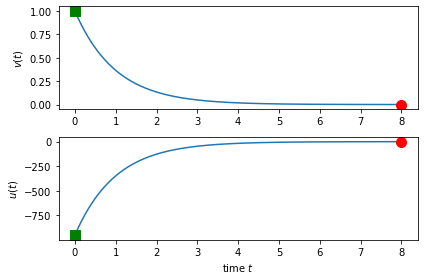

In [15]:
def f_LTI(t,x,u):
  # x is a 1-D array, i.e. a "row", so we left-multiply the transpose of (A-BK)
  return np.dot(x,(A-np.dot(B,K)).T)

# simulation duration, timestep
T = 8.
dt = 1e-2

# non-zero initial state
v0 = 1.
x0 = np.array([v0])

# zero input
def u(t):
  ut = 0
  return ut
# this could equivalently be written in one line:
# u = lambda t : 0.

# numerical simulation returns:
# t_ - size N array
# x_ - size N x 2 array (since the state is 2-dimensional)
t_,x_ = numerical_simulation(f_LTI,T,x0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
theta_ = x_[:,0]

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt

# plot theta
plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,theta_,label='(Linear)')
plt.plot(t_[0],theta_[0],'gs',ms=10)
plt.plot(t_[-1],theta_[-1],'ro',ms=10)
plt.ylabel(r'$v(t)$')

# plot dtheta
u = -K*x_ # also -K@x or -np.multiply(K,x)
plt.subplot(2,1,2)
plt.plot(t_,u,label='(Linear)')
plt.plot(t_[0],u[0],'gs',ms=10)
plt.plot(t_[-1],u[-1],'ro',ms=10)
plt.ylabel(r'$u(t)$')
plt.xlabel(r'time $t$')

plt.tight_layout();

# # phase portrait
# plt.figure()
# plt.subplot(1,1,1)
# plt.plot(theta_,dtheta_,label='(Linear)')
# plt.plot(theta_[0],dtheta_[0],'gs',ms=10)
# plt.plot(theta_[-1],dtheta_[-1],'ro',ms=10)
# plt.ylabel(r'$\dot{\theta}(t)$')
# plt.xlabel(r'${\theta}(t)$')

# plt.tight_layout();

### 6b. state estimation

- pole placement / eigenvalue assignment -- how to pick? 
- determine shape of $L$
- determine values of $L$ symbolically and numerically 

In [16]:
zeta = 5*p
L = -np.array(ctrl.place(A.T,C.T,zeta).T)
L 

array([[-4.95]])

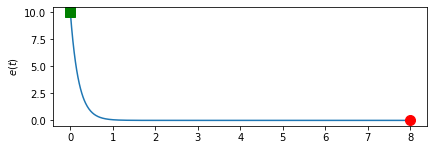

In [17]:
# vector field
def f_error(t,e,u):
  # x is a 1-D array, i.e. a "row", so we left-multiply the transpose of (A-LC)
  return np.dot(e,(A+np.dot(L,C)).T)

# non-zero initial state
error0 = 10.
e0 = np.array([error0])

# zero input
def u(t):
  ut = 0
  return ut
# this could equivalently be written in one line:
# u = lambda t : np.sin(t)

# numerical simulation returns:
# t_ - size N array
# e_ - size N x 2 array (since the state is 2-dimensional)
t_,e_ = numerical_simulation(f_error,T,e0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
error_ = e_[:,0]

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt

# plot theta
plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,error_,label='(Linear)')
plt.plot(t_[0],error_[0],'gs',ms=10)
plt.plot(t_[-1],error_[-1],'ro',ms=10)
plt.ylabel(r'$e(t)$')

# # plot dtheta
# plt.subplot(2,1,2)
# plt.plot(t_,derror_,label='(Linear)')
# plt.plot(t_[0],derror_[0],'gs',ms=10)
# plt.plot(t_[-1],derror_[-1],'ro',ms=10)
# plt.ylabel(r'$\dot{e}(t)$')
# plt.xlabel(r'time $t$')

plt.tight_layout();

# # phase portrait
# plt.figure()
# plt.subplot(1,1,1)
# plt.plot(error_,derror_,label='(Linear)')
# plt.plot(error_[0],derror_[0],'gs',ms=10)
# plt.plot(error_[-1],derror_[-1],'ro',ms=10)
# plt.ylabel(r'$\dot{e}(t)$')
# plt.xlabel(r'$e(t)$');

# plt.tight_layout();

### 6c. stabilizing controller

- why do we do this?

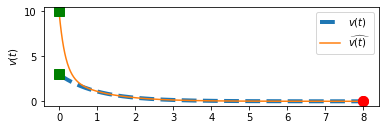

In [25]:
# closed-loop vector field
def f_cl(t,z,u): 
  
  # extract controlled system and observer system state from full system state
  x,x_hat = z[0],z[1] # equivalent to z[0:2],z[2:-1]
  
  # compute control input using observer state
  u = -np.dot(x_hat,K.T)
  
  # output from controlled system and observer system
  y = np.dot(x,C.T) + np.dot(u,D.T)
  y_hat = np.dot(x_hat,C.T) + np.dot(u,D.T)
  
  # dynamics of controlled system and observer system
  dx = f_LTI(t,x,u)
  dx_hat = np.dot(x_hat,A.T) + np.dot(u,B.T) - np.dot((y-y_hat),L.T)
  
  # combine dynamics of controlled system and observer system
  dz = np.hstack((np.squeeze(dx),np.squeeze(dx_hat)))

  return dz

v0 = 3.
v0_hat = 10.

# non-zero initial state
z0 = np.array([v0, v0_hat])

# zero input
def u(t):
  ut = 0
  return ut
# this could equivalently be written in one line:
# u = lambda t : np.sin(t)

# numerical simulation returns:
# t_ - size N array
# z_ - size N x 2 array (since the state is 2-dimensional)
t_,z_ = numerical_simulation(f_cl,T,z0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
x_ = z_[:,0]
x_hat_ = z_[:,1]
# theta_,dtheta_, = x_.T
# theta_hat_,dtheta_hat_, = x_hat_.T

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt
plt.figure()

# plot theta, theta_hat
plt.subplot(2,1,1)
plt.plot(t_,x_,'--',lw=4,label=r'$v(t)$')
plt.plot(t_,x_hat_,label=r'$\widehat{v(t)}$')
plt.plot(t_[0],x_[0],'gs',ms=10)
plt.plot(t_[-1],x_[-1],'ro',ms=10)
plt.plot(t_[0],x_hat_[0],'gs',ms=10)
plt.plot(t_[-1],x_hat_[-1],'ro',ms=10)
plt.ylabel(r'$v(t)$')
plt.legend();

# # plot dtheta, dtheta_hat
# plt.subplot(2,1,2)
# plt.plot(t_,dtheta_,'--',lw=4,label=r'$\dot{\theta}$')
# plt.plot(t_,dtheta_hat_,label=r'$\dot{\widehat{\theta}}$')
# plt.plot(t_[0],dtheta_[0],'gs',ms=10)
# plt.plot(t_[-1],dtheta_[-1],'ro',ms=10)
# plt.plot(t_[0],dtheta_hat_[0],'gs',ms=10)
# plt.plot(t_[-1],dtheta_hat_[-1],'ro',ms=10)
# plt.ylabel(r'$\dot{\theta}(t)$')
# plt.xlabel(r'time $t$')

# plt.figure()
# plt.subplot(1,1,1)
# plt.plot(theta_,dtheta_,'--',lw=4,label=r'$x$')
# plt.plot(theta_hat_,dtheta_hat_,label=r'$\widehat{x}$')
# plt.plot(theta_[0],dtheta_[0],'gs',ms=10)
# plt.plot(theta_[-1],dtheta_[-1],'ro',ms=10)
# plt.plot(theta_hat_[0],dtheta_hat_[0],'gs',ms=10)
# plt.plot(theta_hat_[-1],dtheta_hat_[-1],'ro',ms=10)
# plt.ylabel(r'$\dot{\theta}(t)$')
# plt.xlabel(r'${\theta}(t)$')
# plt.legend();

### 6c. stabilizing controller (nonlinear)

- why do we do this?

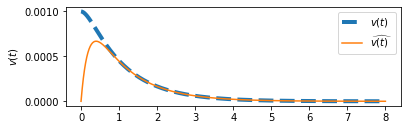

In [36]:
def h_NL(t,x,u):
  return x

def f_NL(t,x,u):
  return np.array([(u-b*x)/m])

# vector field
def f_cl(t,z,u): 
  
  # extract controlled system and observer system state from full system state
  x,x_hat = z[0],z[1]
  
  # compute control input using observer state
  u = -np.dot(x_hat,K.T)
  
  # output from controlled system and observer system
  y = h_NL(t,x,u)
  y_hat = np.dot(x_hat,C.T) + np.dot(u,D.T)
  
  # dynamics of controlled system and observer system
  dx = f_NL(t,x,u)
  dx_hat = np.dot(x_hat,A.T) + np.dot(u,B.T) - np.dot((y-y_hat),L.T)
  
  # combine dynamics of controlled system and observer system
  dz = np.hstack((np.squeeze(dx),np.squeeze(dx_hat)))

  return dz

# NOTE:  nonlinear system's initial state needs to be VERY close to x_e
v0 = .001
v0_hat = 0.

# non-zero initial state
z0 = np.array([v0,v0_hat])

# zero input
def u(t):
  ut = 0
  return ut
# this could equivalently be written in one line:
# u = lambda t : np.sin(t)

# numerical simulation returns:
# t_ - size N array
# z_ - size N x 2 array (since the state is 2-dimensional)
t_,z_ = numerical_simulation(f_cl,T,z0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
x_ = z_[:,0]
x_hat_ = z_[:,1]
# theta_,dtheta_, = x_.T
# theta_hat_,dtheta_hat_, = x_hat_.T

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt
plt.figure()

# plot theta, theta_hat
plt.subplot(2,1,1)
plt.plot(t_,x_,'--',lw=4,label=r'$v(t)$')
plt.plot(t_,x_hat_,label=r'$\widehat{v(t)}$')
plt.ylabel(r'$v(t)$')
plt.legend()

# # plot dtheta, dtheta_hat
# plt.subplot(2,1,2)
# plt.plot(t_,dtheta_,'--',lw=4,label=r'$\dot{\theta}$')
# plt.plot(t_,dtheta_hat_,label=r'$\dot{\widehat{\theta}}$')
# plt.ylabel(r'$\dot{\theta}(t)$')
# plt.xlabel(r'time $t$')

# plt.figure()
# plt.subplot(1,1,1)
# plt.plot(theta_,dtheta_,'--',lw=4,label=r'$x$')
# plt.plot(theta_hat_,dtheta_hat_,label=r'$\widehat{x}$')
# plt.ylabel(r'$\dot{\theta}(t)$')
# plt.xlabel(r'${\theta}(t)$')
# plt.legend();

## week 7: frequency analysis

### 7a. state space to transfer function

$$G_{yu}(s)=C(sI-A)^{-1}B+D$$

- algebraically or computationally

In [37]:
A = sym.Matrix([[-b/m]])
B = sym.Matrix([[1/m]])
C = sym.Matrix([[1]]).T
sym.var("s")
Gyu = C*(s*sym.eye(1)-A).inv()*B
Gyu = Gyu[0].simplify().cancel()
Gyu

   0.001    
────────────
1.0⋅s + 0.05

### 7b. bode plots

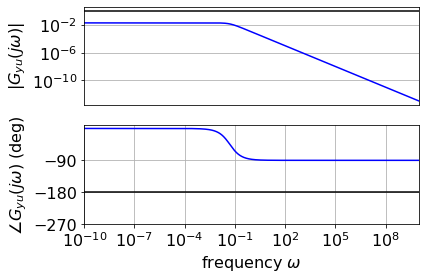

In [41]:
Gyu_ = sym.lambdify(s,Gyu)

omega = np.logspace(-1e1,1e1,1000)
xlim = omega[[0,-1]]

abs_L = np.abs(Gyu_(1.j*omega))
angle_L = np.unwrap(np.angle(Gyu_(1.j*omega)))*180./np.pi

# critical = (angle_L < -180).nonzero()[0][0]

plt.figure(); axs = []
ax = plt.subplot(2,1,1); ax.grid('on')
ax.loglog(omega,abs_L,'b-')
ax.loglog(xlim,[1.,1.],'k-')
# ax.loglog(omega[critical],abs_L[critical],'ro')
ax.set_ylabel(r'$|G_{yu}(j\omega)|$')
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid('on')
ax.semilogx(omega,angle_L,'b-')
ax.semilogx(xlim,[-180.,-180.],'k-')
# ax.semilogx(omega[critical],angle_L[critical],'ro')
ax.set_xlabel(r'frequency $\omega$')
ax.set_ylabel(r'$\angle G_{yu}(j\omega)$ (deg)')
ax.set_yticks([-90,-180,-270])
ax.set_xlim(xlim)
axs.append(ax)

for ax in axs:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
               ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)

### 7c effect of disturbances

can't simultaneously reject disturbances on input and output at the same time
- sensitivity $G_{yw}=S(j\omega)=\frac{1}{1+PC}$, e.g. sensor noise
- and complementary sensitivity $-G_{uv} = T(j\omega)=\frac{PC}{1+PC}$, e.g. wind pushing on car, hill

can't reshape $S$ to whatever you desire - Bode integral formula / principle
- any range of frequencies where controller attenuates disturbance is compensated by a range where controller amplifies disturbance

## week 8: frequency control

### 8a. Nyquist stability criterion

if $L = PC$ has no poles in the right-half plane, then $\frac{L}{1+L}$ is stable $\leftrightarrow$ $\Omega$ does not encircle $-1\in\mathbb{C}$

Nyquist plot: $\Omega=\{L(j\omega)\in\mathbb{C}: -\infty<\omega<\infty\}$

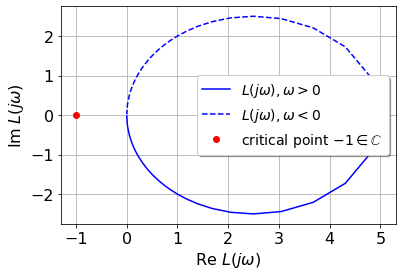

In [44]:
P = .001 / (s+.05)
C = 250.
PC = sym.lambdify(s,P*C)

omega = np.linspace(0.,1e1,1000)

Omega = PC(1.j*omega)

plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

### 8b. gain, phase, and stability margins

* *stability margin* $s_m$ = distance from $\Omega$ to $-1\in\mathbb{C}$;
* *gain margin* $g_m$ = smallest increase in gain that causes $\Omega$ to encircle $-1$ (computed as the inverse of distance from $\Omega$ to $-1\in\mathbb{C}$);
* *phase margin* $\varphi_m$ = smallest change in phase that causes $\Omega$ to encircle $-1$ (computed as the distance from $\Omega$ to $-1\in\mathbb{C}$ restricted to rotation of $\Omega$).

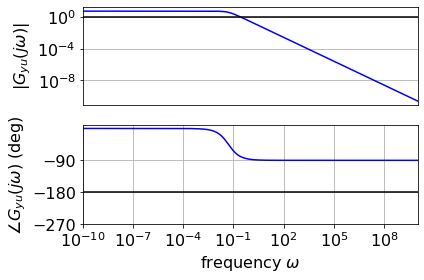

In [45]:
omega = np.logspace(-1e1,1e1,1000)
xlim = omega[[0,-1]]

abs_L = np.abs(PC(1.j*omega))
angle_L = np.unwrap(np.angle(PC(1.j*omega)))*180./np.pi

# critical = (angle_L < -180).nonzero()[0][0]

plt.figure(); axs = []
ax = plt.subplot(2,1,1); ax.grid('on')
ax.loglog(omega,abs_L,'b-')
ax.loglog(xlim,[1.,1.],'k-')
# ax.loglog(omega[critical],abs_L[critical],'ro')
ax.set_ylabel(r'$|G_{yu}(j\omega)|$')
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid('on')
ax.semilogx(omega,angle_L,'b-')
ax.semilogx(xlim,[-180.,-180.],'k-')
# ax.semilogx(omega[critical],angle_L[critical],'ro')
ax.set_xlabel(r'frequency $\omega$')
ax.set_ylabel(r'$\angle G_{yu}(j\omega)$ (deg)')
ax.set_yticks([-90,-180,-270])
ax.set_xlim(xlim)
axs.append(ax)

for ax in axs:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
               ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)

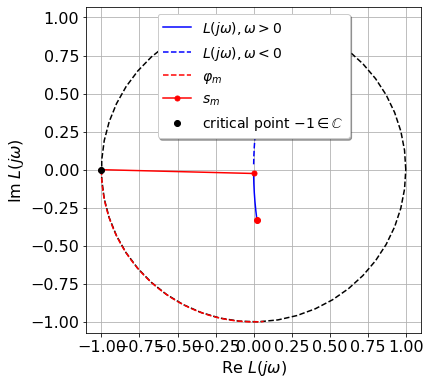

In [49]:

omega = np.linspace(0.75,1e1,1000)
Omega = PC(1.j*omega)

abs_L = np.abs(Omega)
angle_L = np.unwrap(np.angle(Omega))*180./np.pi

circle = np.exp(1.j*np.linspace(0.,2*np.pi))

# index (i.e. entry) of Omega array corresponding to stability margin
# g_m_idx = (angle_L < -180).nonzero()[0][0]
phi_m_idx = np.argmin(np.min(np.abs(Omega - circle[:,np.newaxis]),axis=0))
s_m_idx = np.argmin(np.abs(Omega - (-1.)))

# numerical value of stability margin
# g_m = -1./Omega[g_m_idx].real
phi_m = np.angle(Omega[phi_m_idx])*180./np.pi
phi_m_arc = np.exp(1.j*np.linspace(-180,phi_m)*np.pi/180.)
s_m = np.abs(Omega[s_m_idx] - (-1.))

axs = []

plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1); ax.grid('on'); ax.axis('equal')
# Omega, i.e. graph of L(j omega)
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
# unit circle
ax.plot(circle.real,circle.imag,'k--')
# stability margins
# ax.plot(-1./g_m,0.,'ro',label=r'$-1/g_m$')
ax.plot(phi_m_arc.real,phi_m_arc.imag,'r--',label=r'$\varphi_m$')
ax.plot(Omega[phi_m_idx].real,Omega[phi_m_idx].imag,'ro')
ax.plot([-1.,Omega[s_m_idx].real],[0.,Omega[s_m_idx].imag],'r.-',ms=10,label=r'$s_m$')
# critical point (-1. + 0.j)
ax.plot(-1.,0.,'ko',label=r'critical point $-1\in\mathbb{C}$')
# legend and labels
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');
axs.append(ax)

for ax in axs:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
               ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)

### 8c. root locus

general idea: for a causal plant $P$ with proportional feedback controller $C(s) = K$, the closed-loop system $\frac{PC}{1+PC}$ will approximately behave like the poles of $P(s)$ at small $K$s and more like the zeros of $P(s)$ at large $K$s. 

- this will not be on the exam